# Manipulate data
In this notebook the reference data and the user data are manipulated

In [1]:
#Imports
import json
import geopandas as gpd
from shapely import Polygon, MultiPolygon

## Reference countries
I used the following dataset <br>https://public.opendatasoft.com/explore/dataset/country_shapes/information/?location=2,-32.99024,1.40625&basemap=jawg.light<br> for the country reference shapes. The cells below contain the modification made to the data. 

In [5]:
ref_gdf = gpd.read_file('./data/reference.geojson')
ref_gdf

,geo_point_2d,cntry_name,join_name,iso2_2,iso_a2,iso2,cou_iso3_code,iso3,UN,geometry
0,"{'lon': -170.707833227, 'lat': -14.3044053954}",American Samoa,American Samoa,AS,None,AS,ASM,ASM,False,"POLYGON ((-170.74390 -14.37556, -170.74942 -14..."
1,"{'lon': 90.4294341107, 'lat': 27.4154148028}",Bhutan,Bhutan,None,BT,BT,BTN,BTN,True,"POLYGON ((92.08151 26.86905, 92.06443 26.85972..."
2,"{'lon': 15.2242938734, 'lat': -0.84023182197}",Congo,Congo,None,CG,CG,COG,COG,True,"POLYGON ((15.89050 -3.94301, 15.88028 -3.95111..."
3,"{'lon': -73.0732149222, 'lat': 3.90074916277}",Colombia,Colombia,None,CO,CO,COL,COL,True,"MULTIPOLYGON (((-81.71306 12.49028, -81.72014 ..."
4,"{'lon': 20.4828261146, 'lat': 6.57134077717}",Central African Republic,Central African Rep.,None,CF,CF,CAF,CAF,True,"POLYGON ((20.45330 4.52379, 20.45798 4.61931, ..."
...,...,...,...,...,...,...,...,...,...,...
232,"{'lon': -62.1869336173, 'lat': 16.7353646189}",Montserrat,Montserrat,MS,None,MS,MSR,MSR,False,"POLYGON ((-62.17139 16.67139, -62.19000 16.672..."
233,"{'lon': 14.4419214047, 'lat': 35.8905224404}",Malta,Malta,MT,None,MT,MLT,MLT,True,"POLYGON ((14.51972 35.80000, 14.42389 35.81860..."
234,"{'lon': 167.952596797, 'lat': -29.0376570493}",Norfolk Island,Norfolk Island,NF,None,NF,NFK,NFK,False,"POLYGON ((167.96497 -29.08111, 167.92358 -29.0..."
235,"{'lon': 54.3350646496, 'lat': 23.9104341342}",United Arab Emirates,United Arab Emirates,None,AE,AE,ARE,ARE,True,"MULTIPOLYGON (((56.28047 24.85727, 56.26944 24..."


### DONE: Filter countries with sparse area
Lets filter out the countries wich are extremly sparse 

In [159]:
def filter_coverage(geom, minimum=0.02):
    xmin, ymin, xmax, ymax = geom.bounds
    bounding_area = (ymax - ymin) * (xmax - xmin)
    coverage = geom.area / bounding_area
    return coverage > minimum

In [160]:
ref_gdf = ref_gdf[ref_gdf['geometry'].apply(filter_coverage)].reset_index(drop=True)

In [162]:
#ref_gdf.to_file('./data/reference.geojson')

### DONE: Split countries
Some countries lie on the antimeridian which causes problems. Lets fix this 

In [359]:
from shapely.affinity import translate


def merge_split_country(row):
    xmin, ymin, xmax, ymax = row.bounds
    if xmax - xmin > 130 and not row.crosses(LineString([[0, -90], [0, 90]])):
        polygons = []
        for poly in row.geoms:
            _, _, maxx, _ = poly.bounds
            if maxx < 0:
                poly = translate(poly, xoff=360)
            polygons.append(poly)
            
        country = polygons[0]
        for poly in polygons[1:]:
            country = country.union(poly)
    
        return country
    else:
        return row

In [360]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(merge_split_country)

This code doesn't work for antarctica, so will omit Antarctica from the data

In [ ]:
ref_gdf = ref_gdf[ref_gdf.cntry_name != 'Antarctica'].reset_index(drop=True)

In [414]:
#ref_gdf.to_file('./data/reference.geojson')

### DONE: Remove small islands seperated from the mainland
Some countries, like Chile and Denmark, have a small island that is seperated from the mainland by a large distane. 
Lets remove these "outliers"

In [593]:
def rm_outlier(geom, min_length=0.8, min_area=0.05):
    if isinstance(geom, Polygon):
        return geom

    #Get current geom boundary length 
    xmin, ymin, xmax, ymax = geom.bounds
    geom_length = (xmax - xmin) + (ymax - ymin)
        
    polygons = [poly for poly in geom.geoms]
    new_polygons = []
    for idx in range(len(polygons)):
        subset = polygons.copy()
        poly = subset.pop(idx)
        new_geom = MultiPolygon(subset)
        xmin, ymin, xmax, ymax = new_geom.bounds
        length = (xmax - xmin) + (ymax - ymin)
        #Check if the polygon should be omitted 
        if (length / geom_length) > min_length or (poly.area / geom.area) > min_area:
            new_polygons.append(poly)
    
    return MultiPolygon(new_polygons)

In [595]:
ref_gdf['geometry'] = ref_gdf['geometry'].apply(rm_outlier)

In [596]:
#ref_gdf.to_file('./data/reference.geojson')

### Countries with very few coordinates
Some countries consists of very few coordinates. I could filter these out.

In [ ]:
from countryguess.utils import decompose


for index, row in ref_gdf.iterrows():
    points = sum([len(poly.exterior.coords) for poly in decompose(row.geometry)])
    if points < 15:
        print(row.cntry_name, points)

## User drawings

In [41]:
def init_user_data(path='./data/drawings.geojson'):
    # Initialize an empty GeoJSON object
    geojson_output = {
        "type": "FeatureCollection",
        "features": []}
    
    # Write the empty GeoJSON object to a file
    with open(path, 'w') as f:
        json.dump(geojson_output, f)

In [2]:
def remove_drawing(idx, path='./data/drawings.geojson'):
    with open(path, 'r') as f:
        user_data = json.load(f)

    idx = len(user_data['features']) - 1 if idx==-1 else idx
    
    # Check if the index is valid
    if idx >= 0 and idx < len(user_data['features']):
        removed_feature = user_data['features'].pop(idx)
        print(f"Row at index {idx} removed from {path}.")
    else:
        print("Invalid index.")

    with open(path, 'w') as f:
        json.dump(user_data, f)

In [3]:
user_gdf = gpd.read_file('./data/drawings.geojson')
user_gdf

,cntry_name,timestamp,geometry
0,Denmark,2024-04-13 15:24:33.402,"MULTILINESTRING ((7.62900 7.37313, 7.62900 7.3..."
1,Cameroon,2024-04-13 18:35:43.835,"MULTILINESTRING ((45.64269 62.00000, 44.66821 ..."
2,Chile,2024-04-13 18:49:01.942,"MULTILINESTRING ((26.21384 62.00000, 26.21384 ..."
3,Peru,2024-04-13 18:50:25.626,"MULTILINESTRING ((7.01859 45.49442, 8.57993 46..."
4,Venezuela,2024-04-13 18:52:13.828,"MULTILINESTRING ((8.23077 51.84615, 7.07692 50..."
5,Belize,2024-04-13 19:05:46.957,"MULTILINESTRING ((25.19512 2.43902, 26.21951 2..."
6,Mexico,2024-04-13 19:07:53.642,"MULTILINESTRING ((2.80717 58.50224, 3.74888 58..."
7,United States of America,2024-04-13 20:34:47.098,"MULTILINESTRING ((25.27586 38.29310, 26.65517 ..."
8,Taiwan,2024-04-13 20:36:34.279,"MULTILINESTRING ((31.22857 6.80000, 31.40000 8..."
9,Chile,2024-04-16 09:15:17.773,"MULTILINESTRING ((29.76805 60.16193, 30.55580 ..."


In [4]:
#remove_drawing(-1)

Row at index 23 removed from ./data/drawings.geojson.


### Plot user drawings

In [5]:
import matplotlib.pyplot as plt
from countryguess.data import TestDataset

In [6]:
test_data = TestDataset(shape=(128, 128))

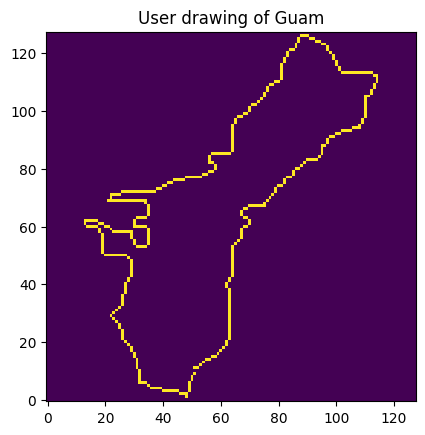

In [11]:
sample = test_data[22]
plt.imshow(sample["drawing"], interpolation='nearest', origin='lower')
plt.title(f"User drawing of {sample['country_name']}") 
plt.show()